In [1]:
import pinocchio as pin
import numpy as np

MODEL = "pendulum"

# Load the URDF model
model = pin.buildModelFromUrdf(f"model/{MODEL}/model.urdf")
data = model.createData()

In [2]:
from mujoco_logger import SimLog

# load data
log = SimLog(f"data/{MODEL}.json")

log[0].qpin, log[0].vpin, log[0].dv, log[0].u

(array([0.]), array([0.]), array([0.]), array([0.]))

In [3]:
A = []
b = []

# for i in range(len(log)):
for i in range(len(log)):
    regressor = pin.computeJointTorqueRegressor(
        model,
        data,
        log[i].qpin,
        log[i].vpin,
        log[i].dv,
    )

    # check if regressor is flat
    if len(regressor.shape) != 2:
        A.append(regressor)
    else:
        A.extend(regressor)

    b.extend(log[i].u)

A = np.array(A)
b = np.array(b)

A.shape, b.shape

((20000, 10), (20000,))

In [4]:
# compute sum for each column in matrix A
sums = np.sum(A, axis=0)

# find indices with zeros
indices = np.where(sums == 0)
# indices = []

indices, sums

((array([0, 2, 4, 5, 7, 8, 9]),),
 array([    0.        , 22722.3947498 ,     0.        ,  -428.58755968,
            0.        ,     0.        , 16397.18130707,     0.        ,
            0.        ,     0.        ]))

In [5]:
# create new matrix with only non-zero columns
A = np.delete(A, indices, axis=1)

A.shape

(20000, 3)

# Parameters we obtain from linear regression

In [6]:
# Solve the least square problem
x = np.linalg.lstsq(A, b, rcond=None)[0]
with np.printoptions(precision=3, suppress=True):
    print(x)

[-0.008  0.3    1.09 ]


# Ground truth parameters

In [7]:
all_base = []
for i in range(1, model.njoints):
    all_base.extend(model.inertias[i].toDynamicParameters())

all_base = np.array(all_base)

# filter from indices
all_base = np.delete(all_base, indices, axis=0)

all_base

array([0.  , 0.3 , 1.09])

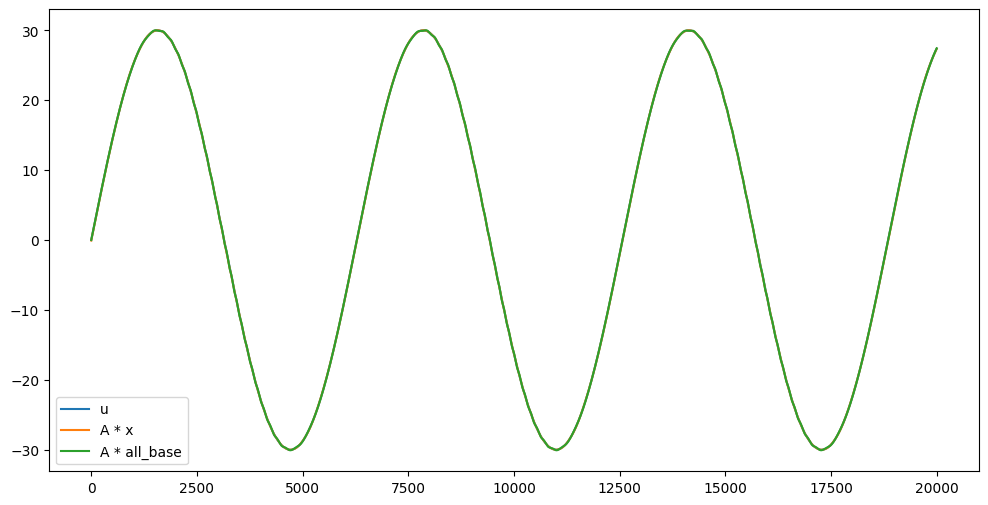

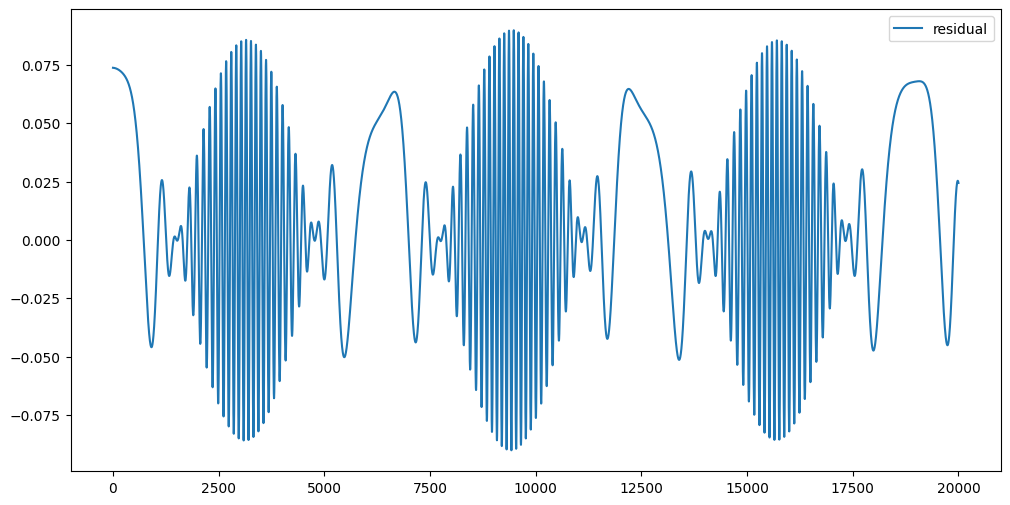

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(b, label="u")
plt.plot(A @ x, label="A * x")
plt.plot(A @ all_base, label="A * all_base")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(b - A @ x, label="residual")
plt.legend()
plt.show()